# Predictive Maintenance Baseline (CMAPSS FD001)
This notebook builds the CM1 baseline:
1. Load CMAPSS FD001
2. Create RUL and warning labels
3. Leakage-free train/val split by engine
4. Scaling
5. Baseline Random Forest (RUL regression & warning classification)
6. Metrics for CM1 report

## 0. Imports / setup
Install dependencies if needed:
```bash
pip install pandas scikit-learn numpy matplotlib
```

In [6]:
import os
import zipfile
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt


## 1. Load CMAPSS FD001 data
- `CMAPSSData (1).zip` should be next to this notebook (or update the path).
- We extract it and load `train_FD001.txt`, `test_FD001.txt`, `RUL_FD001.txt`. 


In [7]:
zip_path = 'CMAPSSData.zip'  # change if needed
extract_dir = 'cmapss_extracted'

if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_dir)

train_path = os.path.join(extract_dir, 'train_FD001.txt')
test_path  = os.path.join(extract_dir, 'test_FD001.txt')
rul_path   = os.path.join(extract_dir, 'RUL_FD001.txt')

train_raw = pd.read_csv(train_path, sep=r'\s+', header=None)
test_raw  = pd.read_csv(test_path,  sep=r'\s+', header=None)
rul_raw   = pd.read_csv(rul_path,   sep=r'\s+', header=None)

print('train shape:', train_raw.shape)
print('test shape :', test_raw.shape)
print('rul shape  :', rul_raw.shape)
train_raw.head()

train shape: (20631, 26)
test shape : (13096, 26)
rul shape  : (100, 1)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 2. Label engineering (RUL + warning_flag)
We name the columns and compute:
- RUL = max_cycle(engine) - current_cycle
- warning_flag = 1 if RUL <= 30 cycles else 0

In [8]:
columns = [
    'engine_id', 'cycle',
    'os1', 'os2', 'os3',
] + [f's{i}' for i in range(1,22)]

train_raw.columns = columns
test_raw.columns  = columns

# max cycle per engine (failure point)
max_cycles = train_raw.groupby('engine_id')['cycle'].max()

# merge so each row knows that engine's final cycle
train_with_rul = train_raw.merge(
    max_cycles,
    on='engine_id',
    suffixes=('', '_max')
)

# compute RUL
train_with_rul['RUL'] = train_with_rul['cycle_max'] - train_with_rul['cycle']

# define early warning classification label
threshold = 30
train_with_rul['warning_flag'] = (train_with_rul['RUL'] <= threshold).astype(int)

train_with_rul[['engine_id','cycle','RUL','warning_flag']].head(10)

,engine_id,cycle,RUL,warning_flag
0,1,1,191,0
1,1,2,190,0
2,1,3,189,0
3,1,4,188,0
4,1,5,187,0
5,1,6,186,0
6,1,7,185,0
7,1,8,184,0
8,1,9,183,0
9,1,10,182,0


## 3. Train/Validation split (no leakage)
We split by engine_id, not by rows, so validation engines were never seen in training.

In [9]:
engines = train_with_rul['engine_id'].unique()
eng_train, eng_val = train_test_split(
    engines,
    test_size=0.2,
    random_state=42
)

train_df = train_with_rul[train_with_rul['engine_id'].isin(eng_train)].reset_index(drop=True)
val_df   = train_with_rul[train_with_rul['engine_id'].isin(eng_val)].reset_index(drop=True)

print('Train engines:', len(eng_train), ' Val engines:', len(eng_val))
print('Train rows:', train_df.shape, ' Val rows:', val_df.shape)
train_df.head()

Train engines: 80  Val engines: 20
Train rows: (16561, 29)  Val rows: (4070, 29)


,engine_id,cycle,os1,os2,os3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_max,RUL,warning_flag
0,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,...,8.3905,0.03,391,2388,100.0,38.94,23.4585,287,286,0
1,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,...,8.4167,0.03,392,2388,100.0,39.06,23.4085,287,285,0
2,2,3,0.0018,0.0003,100.0,518.67,641.55,1588.32,1398.96,14.62,...,8.3802,0.03,391,2388,100.0,39.11,23.4250,287,284,0
3,2,4,0.0035,-0.0004,100.0,518.67,641.68,1584.15,1396.08,14.62,...,8.4018,0.03,391,2388,100.0,39.13,23.5027,287,283,0
4,2,5,0.0005,0.0004,100.0,518.67,641.73,1579.03,1402.52,14.62,...,8.3867,0.03,390,2388,100.0,39.18,23.4234,287,282,0


## 4. Feature scaling
We z-score normalize os1-3 and s1-s21 using only training stats, then apply to validation.

In [10]:
feature_cols = [c for c in train_df.columns if c.startswith('os') or c.startswith('s')]

X_train = train_df[feature_cols].values
X_val   = val_df[feature_cols].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

y_train_rul = train_df['RUL'].values
y_val_rul   = val_df['RUL'].values

y_train_cls = train_df['warning_flag'].values
y_val_cls   = val_df['warning_flag'].values

len(feature_cols), feature_cols[:10]

(24, ['os1', 'os2', 'os3', 's1', 's2', 's3', 's4', 's5', 's6', 's7'])

## 5. Baseline Models
### 5.1 Random Forest Regressor for RUL
We predict remaining useful life as a continuous value.

We evaluate with RMSE and R².

In [12]:
rfr = RandomForestRegressor(
    n_estimators=200,
    random_state=0
)
rfr.fit(X_train_scaled, y_train_rul)
y_pred_rul = rfr.predict(X_val_scaled)

mse = mean_squared_error(y_val_rul, y_pred_rul)
rmse = mse ** 0.5  # manual square root
r2   = r2_score(y_val_rul, y_pred_rul)

print("=== RUL Regression Performance ===")
print(f"RMSE: {rmse:.2f} cycles")
print(f"R^2 : {r2:.3f}")


=== RUL Regression Performance ===
RMSE: 35.49 cycles
R^2 : 0.708


### 5.2 Random Forest Classifier for Maintenance Warning
warning_flag = 1 means RUL <= threshold cycles (we used 30).

We evaluate with accuracy, confusion matrix, precision, recall, F1.

In [13]:
rfc = RandomForestClassifier(
    n_estimators=200,
    random_state=0
)
rfc.fit(X_train_scaled, y_train_cls)
y_pred_cls = rfc.predict(X_val_scaled)

acc = accuracy_score(y_val_cls, y_pred_cls)
cm  = confusion_matrix(y_val_cls, y_pred_cls)
prec, rec, f1, support = precision_recall_fscore_support(
    y_val_cls,
    y_pred_cls,
    labels=[0,1]
)

print('=== Warning Classification Performance ===')
print(f'Accuracy: {acc:.4f}')
print('Confusion matrix [ [TN FP] [FN TP] ]:')
print(cm)

for label_idx, label in enumerate([0,1]):
    print(f'Class {label}:')
    print(f'  Precision: {prec[label_idx]:.3f}')
    print(f'  Recall   : {rec[label_idx]:.3f}')
    print(f'  F1-score : {f1[label_idx]:.3f}')
    print(f'  Support  : {support[label_idx]}')


=== Warning Classification Performance ===
Accuracy: 0.9646
Confusion matrix [ [TN FP] [FN TP] ]:
[[3394   56]
 [  88  532]]
Class 0:
  Precision: 0.975
  Recall   : 0.984
  F1-score : 0.979
  Support  : 3450
Class 1:
  Precision: 0.905
  Recall   : 0.858
  F1-score : 0.881
  Support  : 620


## 6. Confusion Matrix Heatmap (nice for slides)
This cell draws a normalized confusion matrix with raw counts + %.

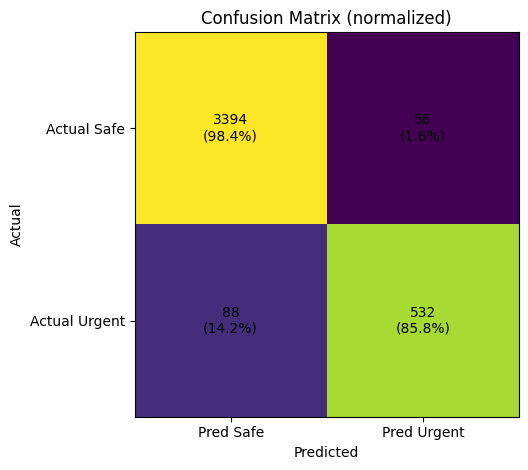

In [14]:
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots()
im = ax.imshow(cm_norm, interpolation='nearest')
ax.set_title('Confusion Matrix (normalized)')
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Pred Safe','Pred Urgent'])
ax.set_yticklabels(['Actual Safe','Actual Urgent'])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i,
                f"{cm[i,j]}\n({cm_norm[i,j]*100:.1f}%)",
                ha='center', va='center')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


## 7. Notes for the report / CM1 slides
- We split by engine_id to avoid leakage.
- We generated two targets: RUL regression and early-warning classification.
- Baseline RFR gives ~35-cycle RMSE and R²≈0.7 on unseen engines.
- Baseline RFC gives ~96% accuracy with ~0.90 precision / ~0.86 recall on 'urgent' class.
- Metrics: RMSE, R², confusion matrix, precision/recall/F1.
- These satisfy the CM1 milestones: dataset chosen, preprocessing, baseline model, evaluation metrics.